# Imports

In [3]:
import os
import sys
import time
import math
import gzip
import json
import uuid
import itertools
import importlib
from pathlib import Path
import csv
import re
import numpy as np
import asyncpg
import glob
import gzip
import pandas as pd
import matplotlib.pyplot as plt

import edcompanion.edsm_api
from edcompanion.calctools import *

def prettyprint(item):
    print(json.dumps(item, indent=4, sort_keys=False))


In [2]:

pgsql_params = dict(
    dsn=os.getenv("PGSQL_URL"),
    server_settings={'search_path': "eddb"}
)
pgpool = await asyncpg.create_pool(**pgsql_params)

NameError: name 'asyncpg' is not defined

In [3]:
print([ dict(R) for R in await pgpool.fetch("SELECT * FROM eddb.systems WHERE name = $1", "Ix")])

[{'id64': 2381282543963, 'x': -65.21875, 'y': 7.75, 'z': -111.03125, 'name': 'Ix'}]


In [8]:
sut = [ 
    dict(R) 
    for R in await pgpool.fetch(f"""
            SELECT * FROM eddb.systems 
            WHERE x between $1 and $2
            AND y between $3 and $4
            AND z between $5 and $6""", 
            -4000,-3800, 200,500,2200,2400)]

In [5]:
sut = [
    dict(**R, **split_id64(R['id64']))
    for R in sut
]
print(len(sut))

1319


: 

In [6]:
df = pd.DataFrame.from_records(sut).set_index(['sector_id', 'id64'])

In [7]:
df.tail(30)

x          y           z  \
sector_id id64                                               
338928    2843135256857 -1986.34375  327.09375  2212.34375   
          2843135650105 -1987.84375  438.81250  2277.59375   
338960    2843403561313 -1980.31250  275.46875  2385.15625   
          2843403954489 -1973.65625  413.96875  2288.68750   
          2843403954513 -1981.81250  398.21875  2337.09375   
          2843404020057 -1975.81250  430.31250  2355.40625   
          2843404151097 -1965.34375  456.65625  2290.18750   
338992    2843672455473 -1953.96875  416.25000  2265.12500   
          2843672521017 -1962.46875  435.90625  2286.15625   
339024    2843940825425 -1935.71875  407.15625  2350.06250   
          2843940890929 -1943.21875  423.71875  2257.65625   
339056    2844208736593 -1909.25000  248.50000  2351.34375   
          2844208998745 -1919.00000  318.21875  2364.25000   
339088    2844477368673 -1890.87500  309.25000  2379.75000   
          2844477565265 -1888.37500  363.09375  2336.90625   
339120    2844745607481 -1865.87500  253.34375  2288.87500   
          2844745607529 -1883.93750  240.65625  2399.43750   
          2844745804113 -1879.84375  311.03125  2347.53125   
339152    2845014042961 -1857.53125  235.78125  2347.93750   
          2845014436121 -1855.15625  365.18750  2208.93750   
339184    2845282412897 -1827.96875  220.15625  2379.87500   
339216    2845550848321 -1818.93750  219.09375  2301.84375   
          2845550913833 -1809.75000  240.15625  2237.56250   
370052    3104221402250 -1980.78125  294.93750  2202.43750   
601168    5042963556713 -1939.12500  240.71875  2395.59375   
          5042963622217 -1930.68750  270.68750  2324.25000   
601232    5043500427569 -1888.43750  254.46875  2259.65625   
601264    5043768863073 -1871.25000  250.15625  2390.62500   
601296    5044037429553 -1847.87500  283.84375  2263.37500   
601328    5044305733913 -1837.65625  242.40625  2200.93750   

                                       name  sector_x  sector_y  sector_z  \
sector_id id64                                                              
338928    2843135256857   Phylur HO-T b32-1         0        20     11248   
          2843135650105   Phylur LQ-N b36-1         0        20     11248   
338960    2843403561313   Phylur WH-D b41-1         0        20     11280   
          2843403954489   Phylur QG-N b36-1         0        20     11280   
          2843403954513   Phylur CZ-H b39-1         0        20     11280   
          2843404020057   Phylur EK-G b40-1         0        20     11280   
          2843404151097   Phylur KV-N b36-1         0        20     11280   
338992    2843672455473   Phylur LF-P b35-1         0        20     11312   
          2843672521017   Phylur NQ-N b36-1         0        20     11312   
339024    2843940825425   Phylur EZ-H b39-1         0        20     11344   
          2843940890929   Phylur MF-P b35-1         0        20     11344   
339056    2844208736593   Phylur VL-G b39-1         0        20     11376   
          2844208998745   Phylur RL-F b40-1         0        20     11376   
339088    2844477368673   Phylur YM-D b41-1         0        20     11408   
          2844477565265   Phylur KP-H b39-1         0        20     11408   
339120    2844745607481   Phylur LT-L b36-1         0        20     11440   
          2844745607529   Phylur JE-B b42-1         0        20     11440   
          2844745804113   Phylur RA-H b39-1         0        20     11440   
339152    2845014042961   Phylur YL-G b39-1         0        20     11472   
          2845014436121   Phylur KY-T b32-1         0        20     11472   
339184    2845282412897   Phylur JT-C b41-1         0        20     11504   
339216    2845550848321   Phylur UU-J b37-1         0        20     11536   
          2845550913833   Phylur GH-P b34-1         0        20     11536   
370052    3104221402250  Phylur SJ-X c15-11         0        22      9604   
601168    5042963556713   Phylur GE-B b42-2    

In [17]:
id64 = 1356915956

In [10]:
split_id64(id64)

{'sector_x': 0,
 'sector_y': 0,
 'sector_z': 161,
 'cube_layer': 6,
 'system_number': 114,
 'body_number': 244}

In [21]:
bits = 14
offset = 0

In [24]:
mask=(2**bits)-1
shift_right = (64 - offset) - bits


In [25]:
mask, shift_right

(16383, 50)

In [ ]:
def get_bits(val):
    return (val  >> shift_right) & mask
return get_bits


# Guardian Archeology

In [4]:
from itertools import accumulate, permutations, combinations, product
from sklearn.cluster import DBSCAN


In [5]:

importlib.reload(edcompanion.edsm_api)
from edcompanion.edsm_api import get_edsm_info, get_systems_in_sphere


### Loading the data

In [6]:
guardiandata_path = os.path.join(os.getcwd(), 'data', 'guardian')
guardiandata_files = {n.split(' - ')[2].split('.')[-2]:os.path.join(guardiandata_path, n) for n in os.listdir(guardiandata_path) if 'Canonn - Guardians' in n}


In [44]:
guardiandata = {}
for n,p in guardiandata_files.items():
    try:
        guardiandata[n] = pd.read_csv(p, delimiter=','    )
    except:
        pass
    

In [45]:
soi = ['Ruins','Structures']

In [46]:
inter_columns = list([i for i in accumulate([set(guardiandata['Guardian '+n].columns) for n in soi], lambda D1, D2: D1 & D2)][-1])
union_columns = list([i for i in accumulate([set(guardiandata['Guardian '+n].columns) for n in soi], lambda D1, D2: D1 | D2)][-1])

column_order_inter = {c:i for c,i in zip(guardiandata['Guardian Beacons'].columns, range(len(guardiandata['Guardian Beacons'].columns))) }
inter_columns = sorted(inter_columns, key=lambda I:column_order_inter.get(I,100))
union_columns = sorted(union_columns, key=lambda I:column_order_inter.get(I,100))

In [47]:

soi_systems = {
    r['System Name']:dict(
        coord=np.asarray([r[c] for c in ['x', 'y', 'z']]),
        info= np.asarray([g] + [r[c] for c in inter_columns])
    )
    for g in soi for i, r in guardiandata['Guardian '+g].iterrows()
}

soi_systemnames = np.vstack([v['info'] for k,v in soi_systems.items()])
soi_coordinates = np.vstack([v['coord'] for k,v in soi_systems.items()])
print(soi_coordinates.shape, soi_systemnames.shape)

(348, 3) (348, 20)


In [48]:
pd.DataFrame(soi_systemnames)[[2]]

,2
0,SYNUEFE XR-H D11-102
1,IC 2391 SECTOR GW-V B2-4
2,IC 2391 SECTOR ZE-A D101
3,SYNUEFE XO-P C22-17
4,SYNUEFE ZL-J D10-119
...,...
343,NGC 2451A Sector OI-S b4-7
344,NGC 2451A Sector IW-W c1-10
345,Wregoe JM-L c21-5
346,Col 173 Sector YC-G c12-17


#### Caching EDSM info 

In [49]:
print(os.path.join(os.getcwd(),'data','guardian','systems_db.json'))

c:\Users\fenke\repos\EDCompanion\data\guardian\systems_db.json


In [50]:
with open(os.path.join(os.getcwd(),'data','guardian','systems_db.json'), 'rt') as jsonfile:
    systems_db = json.load(jsonfile)

if not systems_db:
    systems_db ={S:get_edsm_info(S) for S in soi_systems}
    with open(os.path.join(os.getcwd(),'data','guardian','systems_db.json'), 'wt') as jsonfile:
        json.dump(systems_db, jsonfile, indent=3)

else:
    updates = {S:get_edsm_info(S) for S in soi_systems if S not in systems_db}
    if updates:
        systems_db.update(updates)
        with open(os.path.join(os.getcwd(),'data','guardian','systems_db.json'), 'wt') as jsonfile:
            json.dump(systems_db, jsonfile, indent=3)


In [51]:

for I in systems_db.values():
    for B in I['bodies']:
        if B['parents'] is None:
            B['parents'] = []

### Expanding data on bodies

In [52]:
# Collect info on system and bodies
df_soi = pd.DataFrame(soi_systemnames, columns=['type']+inter_columns).set_index(['System Name', 'Body Name', 'type']).sort_index()
df_soi.head(5)

,,,SiteId,x,y,z,Primary Star,Body Sub Type,Distance To Arrival,Reported By,Orbital Period,Orbital Eccentricity,Rotational Period,Gravity,Surface Temperature,Region (Journal),Region (Calculated),Volcanism,Site Type
System Name,Body Name,type,,,,,,,,,,,,,,,,,
2MASS J10444160-5947046,1 B,Ruins,158,8614.1875,-116.6875,2733.03125,A (Blue-White) Star,Rocky body,1551,Factabulous,5.909919256,0.000493,5.910027186,0.1317382616,245,Outer Orion Spur,Outer Orion Spur,No volcanism,Alpha
BLAA HYPAI BN-I B26-1,B 4,Ruins,440,1290.3125,-666.375,12299.59375,M (Red dwarf) Star,High metal content world,5106,LilacLight,6.810933696,0.001529,6.810939972,0.2175220303,300,Norma Expanse,Norma Expanse,No volcanism,Gamma
BLAA HYPAI EU-D C13-0,B 4,Ruins,254,1244.25,-752.1875,12307.0,K (Yellow-Orange) Star,High metal content world,413317,Baton,4.99991645,0.000512,5.797376302,0.1785770785,235,Norma Expanse,Norma Expanse,No volcanism,Alpha
BLAA HYPAI LZ-F B27-0,A 5,Ruins,229,1251.4375,-752.71875,12330.53125,M (Red dwarf) Star,High metal content world,56,Astinius,24.525706,0.001055,24.52573264,0.2156859099,298,Norma Expanse,Norma Expanse,No volcanism,Gamma
BLAA HYPAI OZ-O D6-16,4 C,Ruins,232,1285.5,-731.65625,12309.34375,F (White) Star,Rocky body,1012,Baton,5.989166046,0.002326,-5.896148019,0.1670820323,299,Norma Expanse,Norma Expanse,No volcanism,Beta


<Axes: ylabel='Frequency'>

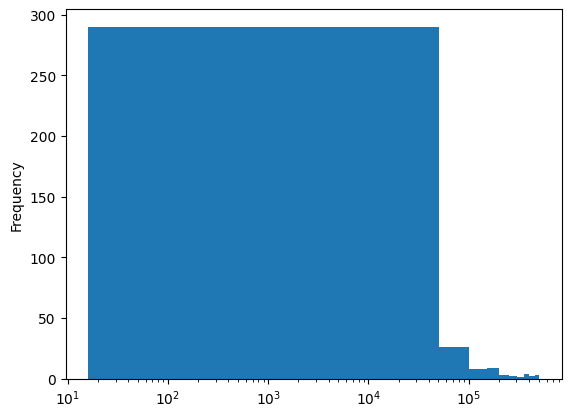

In [53]:
df_soi['Distance To Arrival'].astype(float).plot(kind='hist', logx=True)

In [54]:
df_soi['DATlog'] = np.log10(df_soi['Distance To Arrival'].astype(float))


<Axes: >

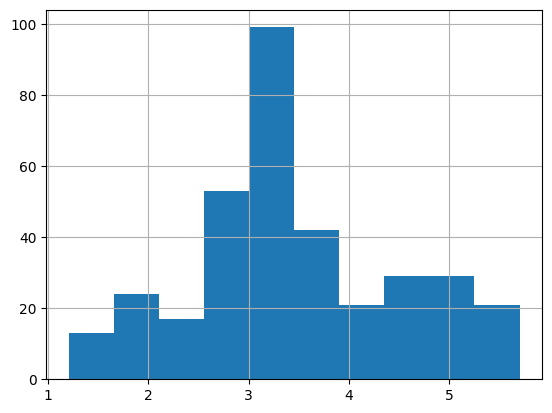

In [55]:
df_soi['DATlog'].hist()

In [56]:
df_soi['Body Sub Type'].value_counts()

Body Sub Type
High metal content world    248
Rocky body                   99
Icy body                      1
Name: count, dtype: int64

In [57]:
body_info = {}
systems_brief ={}

for row in df_soi.reset_index().iterrows():
    data_row = row[1]
    system_name = data_row['System Name'].strip()
    system = systems_db[system_name]
    body_name = f"{system_name} {data_row['Body Name'].strip()}"
    if body_name not in body_info:

        star_bodies = {
            v['bodyId']:len(v['parents']) if v['parents'] is not None else 0
            for v in system['bodies']
            if v['type']=='Star' 
        }
        main_star = [v['bodyId'] for v in system['bodies'] if v.get('isMainStar')][0]
        stars = set(star_bodies.keys())

        body = [B for B in system['bodies'] if B['name'].lower()==body_name.lower()][0]
        body_info[body_name] = body

        parent_star_id = list(
            set(
                [P.get('Star') for P in body['parents'] if 'Star' in P]) &
                stars
        )
        if not parent_star_id:
            parent_star_id = [B['bodyId'] for B in system['bodies'] if B['name'].lower()==system_name.lower()]

        if not parent_star_id:
            parent_stars = sorted(list(star_bodies.keys()), key=lambda x:star_bodies[x])
            print(f"Assuming parent for {body_name} ({body['bodyId']}) kis in {parent_stars}")
        else:
            parent_stars = sorted(parent_star_id, key=lambda x:star_bodies[x], reverse=True)

        body['parent_star_id'] = parent_stars[0]
        
        systems_brief[system_name] = dict(
            bodycount = system['bodyCount'],
            starcount = len(stars),
            mainstar = [v.get('subType','-')[0]  for v in system['bodies'] if v.get('isMainStar')  ],
            stars = '/'.join([v.get('subType','-')[0] for v in system['bodies'] if v['type']=='Star']),

        )

#prettyprint([v['parent_star_id'] for k,v in body_info.items()])

Assuming parent for COL 173 SECTOR JB-F B27-1 BC 3 (14) kis in [1, 3, 4]
Assuming parent for COL 173 SECTOR JI-J B25-0 AB 2 (7) kis in [4, 2, 3]
Assuming parent for COL 173 SECTOR VV-C C13-7 AB 9 A (38) kis in [4, 2, 3]
Assuming parent for EORL AUWSY SY-Z D13-3468 ABC 3 C (40) kis in [1, 24, 3, 4]
Assuming parent for SYNUEFE TP-F B44-0 CD 1 (16) kis in [2, 3, 5, 6]


In [58]:
gsbrief = pd.DataFrame.from_dict(systems_brief, orient='index')
gsbrief.info()

<class 'pandas.core.frame.DataFrame'>
Index: 348 entries, 2MASS J10444160-5947046 to Wregoe JM-L c21-5
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   bodycount  348 non-null    int64 
 1   starcount  348 non-null    int64 
 2   mainstar   348 non-null    object
 3   stars      348 non-null    object
dtypes: int64(2), object(2)
memory usage: 13.6+ KB


In [59]:
gsbrief.describe()

,bodycount,starcount
count,348.000000,348.000000
mean,33.362069,2.965517
std,14.908596,1.342700
min,9.000000,1.000000
25%,22.000000,2.000000
50%,30.000000,3.000000
75%,41.000000,3.000000
max,114.000000,15.000000


In [60]:
gsbrief['bodycount'].value_counts().head(25)

bodycount
19    20
30    17
21    15
25    14
29    13
35    13
26    12
24    12
32    10
20    10
22     9
18     9
42     9
28     9
31     8
38     8
46     8
15     8
36     8
34     7
23     7
27     7
16     7
33     7
17     6
Name: count, dtype: int64

<Axes: >

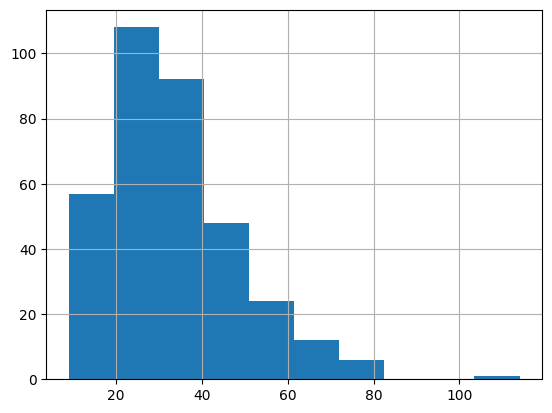

In [61]:
gsbrief['bodycount'].hist()

In [62]:
gsbrief['starcount'].value_counts()

starcount
3     154
2      80
4      52
1      33
5      21
6       5
8       1
15      1
11      1
Name: count, dtype: int64

In [63]:
gsbrief['mainstar'].value_counts()

mainstar
[M]    137
[F]     72
[K]     66
[G]     32
[A]     27
[T]      8
[B]      4
[L]      2
Name: count, dtype: int64

In [64]:
gsbrief['stars'].value_counts().head(20)

stars
M/L      20
M/L/L    19
K/M/L    17
M/M/L    16
F        15
K/M      11
F/Y/Y    10
M/L/T     9
F/Y       9
M/M       9
G         7
K/M/M     7
M/T/L     7
M/M/M     6
M/M/T     6
T/T/T     6
M/L/M     5
F/K       5
A/Y/Y     5
A         5
Name: count, dtype: int64

### Geometric clustering

There is an obvious pattern in the systems that have been discovered

In [73]:
def convert_float(s):
    return float(s.replace(',', '')) if isinstance(s, str) else float(s)

In [74]:
soi_systemnames = np.asarray(
    [[g]+[r[c] for c in inter_columns] for g in soi for i, r in guardiandata['Guardian '+g].iterrows()] )
soi_coordinates = np.asarray([[r[c] for c in ['x', 'y', 'z']] for g in soi for i, r in guardiandata['Guardian '+g].iterrows()])
print(soi_coordinates.shape, soi_systemnames.shape)

(801, 3) (801, 20)


In [75]:
for i,r in guardiandata['Guardian Ruins'].iterrows():
    print(r['System Name'])
    for c in ['x', 'y', 'z']:
        r[c] = convert_float(r[c])


SYNUEFE XR-H D11-102
IC 2391 SECTOR GW-V B2-4
IC 2391 SECTOR ZE-A D101
SYNUEFE XO-P C22-17
SYNUEFE ZL-J D10-119
COL 173 SECTOR KY-Q D5-47
COL 173 SECTOR KY-Q D5-47
HIP 39768
SYNUEFE TP-F B44-0
SYNUEFE TP-F B44-0
SYNUEFE TP-F B44-0
COL 173 SECTOR KY-Q D5-47
SYNUEFE NL-N C23-4
COL 173 SECTOR KY-Q D5-47
SYNUEFE LY-I B42-2
SYNUEFE LY-I B42-2
SYNUEFE LY-I B42-2
COL 173 SECTOR AV-N B23-5
COL 173 SECTOR AV-N B23-5
COL 173 SECTOR AV-N B23-5
COL 173 SECTOR KY-Q D5-47
SYNUEFE NL-N C23-4
COL 173 SECTOR LY-Q D5-13
COL 173 SECTOR LY-Q D5-13
HIP 39768
COL 173 SECTOR LY-Q D5-13
COL 173 SECTOR LY-Q D5-13
COL 173 SECTOR XG-J C10-17
COL 173 SECTOR LY-Q D5-59
COL 173 SECTOR CG-M B24-8
COL 173 SECTOR CG-M B24-8
COL 173 SECTOR CG-M B24-8
COL 173 SECTOR LY-Q D5-59
COL 173 SECTOR LY-Q D5-59
COL 173 SECTOR LY-Q D5-59
COL 173 SECTOR OT-Q D5-18
COL 173 SECTOR OT-Q D5-18
COL 173 SECTOR OT-Q D5-18
COL 173 SECTOR XG-J C10-17
COL 173 SECTOR XG-J C10-17
SYNUEFE CE-R C21-6
SYNUEFE CE-R C21-6
SYNUEFE CE-R C21-6
SYNUEF

In [76]:
soi_systems = {r['System Name']:np.asarray([r[c] for c in ['x', 'y', 'z']]) for g in soi for i, r in guardiandata['Guardian '+g].iterrows()}
soi_systemnames = np.asarray(
    [[g]+[r[c] for c in inter_columns] for g in soi for i, r in guardiandata['Guardian '+g].iterrows()] )
soi_coordinates = np.asarray([[convert_float(r[c]) for c in ['x', 'y', 'z']] for g in soi for i, r in guardiandata['Guardian '+g].iterrows()])
print(soi_coordinates.shape, soi_systemnames.shape)

(801, 3) (801, 20)


#### Clusters

The guardian systems appear clustered, mostly around points of interest along major galactic travel routes

In [77]:
from sklearn.cluster import DBSCAN


In [78]:
soi_coordinates

array([[ 357.34375,  -49.34375,  -74.75   ],
       [ 587.9375 ,  -51.03125,  -38.53125],
       [ 526.5    ,  -86.375  ,  -37.9375 ],
       ...,
       [ 779.53125,   -1.65625, -143.71875],
       [ 990.875  ,  -62.375  , -173.71875],
       [ 896.21875,  -81.90625, -159.0625 ]], shape=(801, 3))

In [79]:
coord_clusters = DBSCAN(eps=160, min_samples=5).fit(soi_coordinates)
#print(np.unique(coord_clusters.labels_))
#print(np.count_nonzero(np.less(coord_clusters.labels_,0)))
print([(l, np.count_nonzero(np.equal(coord_clusters.labels_,l))) for l in np.unique(coord_clusters.labels_)])


[(np.int64(-1), 4), (np.int64(0), 515), (np.int64(1), 25), (np.int64(2), 26), (np.int64(3), 15), (np.int64(4), 25), (np.int64(5), 14), (np.int64(6), 25), (np.int64(7), 21), (np.int64(8), 25), (np.int64(9), 47), (np.int64(10), 14), (np.int64(11), 14), (np.int64(12), 14), (np.int64(13), 12), (np.int64(14), 5)]


A few systems do not fall in any cluster

In [81]:
outliers = np.copy(soi_coordinates[np.less(coord_clusters.labels_,0)])
outlier_systemnames = np.copy(soi_systemnames[np.less(coord_clusters.labels_,0)])

pd.DataFrame([[-1]+n.tolist()+c.tolist() for n,c in zip(outlier_systemnames, outliers)])

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-1,Ruins,361,TRAPEZIUM SECTOR YU-X C1-2,573.59375,-339.46875,-1167.65625,K (Yellow-Orange) Star,1 A,Rocky body,...,8.524807315,0.3059238068,246,Inner Orion Spur,Inner Orion Spur,No volcanism,Alpha,573.59375,-339.46875,-1167.65625
1,-1,Structures,186,TRAPEZIUM SECTOR YU-X C1-2,573.59375,-339.46875,-1167.65625,K (Yellow-Orange) Star,1 A,Rocky body,...,8.524807315,0.3059238068,246,Inner Orion Spur,Inner Orion Spur,No volcanism,Squid,573.59375,-339.46875,-1167.65625
2,-1,Structures,200,WREGOE BU-Y B2-0,1077.375,400.5625,-993.375,M (Red dwarf) Star,1 C,Icy body,...,11.49914532,0.1029534669,58,Unknown,Inner Orion Spur,No volcanism,Stickyhand,1077.37500,400.56250,-993.37500
3,-1,Structures,201,WREGOE BU-Y B2-0,1077.375,400.5625,-993.375,M (Red dwarf) Star,1 C,Icy body,...,11.49914532,0.1029534669,58,Unknown,Inner Orion Spur,No volcanism,Bear,1077.37500,400.56250,-993.37500


Write them out to fit the EDAstro custom marker format

In [82]:
with open(f"custom/guardian-clusters.json", 'wt') as of:
    json.dump(dict(markers=[
            dict(
                pin='red',
                text='\n'.join([f"{cn:20}: {v}" for cn, v in zip(['type'] + inter_columns,row[0])]),
                **{c:v for c,v in zip(['x','y','z'], row[1])}
            )
            for row in [(n,c) for n,c in zip(outlier_systemnames, outliers)]
        ] + [
            dict(
                pin='cyan',
                text=f'Center of cluster {row[0]} with {row[2]} guardian sites',
                **{c:v for c,v in zip(['x','y','z'], row[1])}
            )
            for row in [
                (l, np.round(np.mean(soi_coordinates[np.equal(coord_clusters.labels_,l)], axis=0),2).tolist(), np.count_nonzero(np.equal(coord_clusters.labels_,l)) ) 
                for l in np.unique(coord_clusters.labels_) 
                if not l < 0]
        ]), of, indent=3)
    


## Two line ...

In [83]:
import numpy as np

from scipy.interpolate import interp1d, LinearNDInterpolator
from edcompanion.calctools import *


In [85]:

bkgimage = 'data/visited-systems-indexedregions.png'
bkgimgurl= 'https://edastro.b-cdn.net/mapcharts/visited-systems-indexedregions.png'
bkgimage_scale = 10 # lightyear per pixel
origin=[9000, 7000]
plt_dpi=100

img = plt.imread(bkgimage)


In [35]:
# fig, ax = plt.subplots(figsize=(img.shape[1]/plt_dpi, img.shape[0]/plt_dpi))
# ax.imshow(img)

# fig.savefig('galaxy.png')


#### Clustering the clusters

We cluster the centers of previously found clusters and calculate a line for each 'line cluster' using 

In [86]:
cluster_centers = np.asarray([
    np.round(np.mean(soi_coordinates[np.equal(coord_clusters.labels_,l)], axis=0),2).tolist() 
    for l in np.unique(coord_clusters.labels_) if l >= 0])
line_clusters = DBSCAN(eps=9999, min_samples=3).fit(cluster_centers)
print([(l, np.count_nonzero(np.equal(line_clusters.labels_,l))) for l in np.unique(line_clusters.labels_)])
guardian_lines = {l:cluster_centers[np.equal(line_clusters.labels_,l)] for l in np.unique(line_clusters.labels_)}

[(np.int64(0), 5), (np.int64(1), 10)]


In [87]:
with open(f"custom/two-lines.json", 'wt') as of:
    json.dump(dict(markers=[
            dict(
                pin='yellow', text=f'line 0 {str(row)}',
                **{c:v for c,v in zip(['x','y','z'], row)}
            )
            for row in guardian_lines[0]
        ] + [
            dict(
                pin='green', text=f'line 1 {str(row)}',
                **{c:v for c,v in zip(['x','y','z'], row)}
            )
            for row in guardian_lines[1]
        ]), of, indent=3)

In [89]:
{
    l:np.std(distance_point_to_line(cluster_centers[np.equal(line_clusters.labels_,l)], **line_from_points(cluster_centers[np.equal(line_clusters.labels_,l)])._asdict()))
    for l in np.unique(line_clusters.labels_)
}

{np.int64(0): np.float64(135.37454627898336),
 np.int64(1): np.float64(728.7001380196368)}

#### Clustering on all systems

Alternatively we can cluster on all systems

In [90]:
import edcompanion.calctools
importlib.reload(edcompanion.calctools)
from edcompanion.calctools import *
from sklearn.cluster import DBSCAN

In [91]:
line_clusters_ps = DBSCAN(eps=9999, min_samples=3).fit(soi_coordinates)
print([(l, np.count_nonzero(np.equal(line_clusters_ps.labels_,l))) for l in np.unique(line_clusters_ps.labels_)])

guardian_lines = {l:soi_coordinates[np.equal(line_clusters_ps.labels_,l)] for l in np.unique(line_clusters_ps.labels_)}

[(np.int64(0), 606), (np.int64(1), 195)]


#### Calculate the lines

In [92]:
glines = {
    f"line_{l}":line_from_points(soi_coordinates[np.equal(line_clusters_ps.labels_,l)])._asdict()
    for l in np.unique(line_clusters_ps.labels_)
}

In [93]:
with open(f"data/guardian/glines.json", 'wt') as of:
    json.dump({
        n:{p:a.tolist() for p,a in l.items()}
        for n,l in glines.items()
    },of,indent=3)
with open(f"data/guardian/glines.json", 'rt') as jsonfile:
    print(jsonfile.read())

{
   "line_0": {
      "direction": [
         0.9583219767581116,
         -0.004450699733338385,
         0.2856557020861112
      ],
      "support": [
         1807.4657590759075,
         -160.80383663366337,
         124.46880156765677
      ]
   },
   "line_1": {
      "direction": [
         0.7983973686058519,
         0.016494824324434516,
         0.6019049447992246
      ],
      "support": [
         -1852.5078525641027,
         -480.00240641025636,
         12708.99391025641
      ]
   }
}


Nu even kijken wat het scheelt

In [94]:
list(np.unique(line_clusters.labels_))

[np.int64(0), np.int64(1)]

In [95]:
{
    l:np.std(distance_point_to_line(cluster_centers[np.equal(line_clusters.labels_,l)], **line_from_points(soi_coordinates[np.equal(line_clusters_ps.labels_,l)])._asdict()))
    for l in np.unique(line_clusters.labels_)
}

{np.int64(0): np.float64(160.7738052937673),
 np.int64(1): np.float64(796.4843352093227)}

In [96]:
{
    l:np.dot(cluster_centers[np.equal(line_clusters.labels_,l)], line_from_points(soi_coordinates[np.equal(line_clusters_ps.labels_,l)]).direction)
    for l in np.unique(line_clusters.labels_)
}

{np.int64(0): array([  931.86202544,  9061.18472917,  1125.24548565, 14994.50592132,
          898.4593856 ]),
 np.int64(1): array([ 1929.07151177, -2657.55843557, 16381.92928951,  8383.8198532 ,
         7430.10338669,  7476.42087464,  7495.90835788,  7115.24897289,
         7154.70796888,  7337.80475697])}

In [97]:
gsystem_lines = {
    l:line_from_points(soi_coordinates[np.equal(line_clusters_ps.labels_,l)])._asdict()
    for l in np.unique(line_clusters_ps.labels_)
}


In [98]:
gsystem_lines

{np.int64(0): {'direction': array([ 0.95832198, -0.0044507 ,  0.2856557 ]),
  'support': array([1807.46575908, -160.80383663,  124.46880157])},
 np.int64(1): {'direction': array([0.79839737, 0.01649482, 0.60190494]),
  'support': array([-1852.50785256,  -480.00240641, 12708.99391026])}}

In [99]:
with open(f"custom/projected-clusters.json", 'wt') as of:
        json.dump(dict(markers=[
        dict(
            pin='yellow',
            text=f"cluster {l}, distance {round(distance_point_to_line(cc, **gsystem_lines[l]),1)}\ncentre \t{cc}\nprojected \t{project_point_on_line(cc, **gsystem_lines[l])}",
            **{c:round(v,1) for c,v in zip(['x','y','z'], list(project_point_on_line(cc, **gsystem_lines[l])))}
        )
        for l in np.unique(line_clusters.labels_) 
        for cc in cluster_centers[np.equal(line_clusters.labels_,l)]
        if not l < 0
    ]),of,indent=3)

#### Selective

In [100]:
glines = {
    l:line_from_points(soi_coordinates[np.equal(line_clusters_ps.labels_,l)])
    for l in np.unique(line_clusters.labels_)
}


In [101]:
print(json.dumps({
        n:{p:a.tolist() for p,a in l.items()}
        for n,l in {
            f"line_{l}":glines[l]._asdict()
            for l in glines
        }.items()
    },indent=3))


{
   "line_0": {
      "direction": [
         0.9583219767581116,
         -0.004450699733338385,
         0.2856557020861112
      ],
      "support": [
         1807.4657590759075,
         -160.80383663366337,
         124.46880156765677
      ]
   },
   "line_1": {
      "direction": [
         0.7983973686058519,
         0.016494824324434516,
         0.6019049447992246
      ],
      "support": [
         -1852.5078525641027,
         -480.00240641025636,
         12708.99391025641
      ]
   }
}


In [102]:
glp = {
    l:np.percentile(distance_point_to_line(soi_coordinates[np.equal(line_clusters_ps.labels_,l)], **glines[l]._asdict()), 70)
    for l in np.unique(line_clusters.labels_)
}
print(glp)

{np.int64(0): np.float64(165.37849030435459), np.int64(1): np.float64(677.6029024423171)}


In [103]:
glmask = {
    l:np.less(distance_point_to_line(soi_coordinates[np.equal(line_clusters_ps.labels_,l)], **glines[l]._asdict()), glp[l])
    for l in np.unique(line_clusters.labels_)
}

In [104]:
{
    l:np.count_nonzero(glmask[l])
    for l in glmask
}

{np.int64(0): 424, np.int64(1): 135}

In [105]:
{
    l:np.std(distance_point_to_line(soi_coordinates[np.equal(line_clusters_ps.labels_,l)][glmask[l]], **glines[l]._asdict()))
    for l in glines
}

{np.int64(0): np.float64(41.61426074609766),
 np.int64(1): np.float64(123.81976898121722)}

In [106]:
{
    l:np.mean(distance_point_to_line(soi_coordinates[np.equal(line_clusters_ps.labels_,l)][glmask[l]], **glines[l]._asdict()))
    for l in glines
}

{np.int64(0): np.float64(82.410834486577),
 np.int64(1): np.float64(257.0217386988094)}

In [107]:
glines = {
    l:line_from_points(soi_coordinates[np.equal(line_clusters_ps.labels_,l)][glmask[l]])
    for l in np.unique(line_clusters.labels_)
}

In [108]:
print(json.dumps({
        n:{p:a.tolist() for p,a in l.items()}
        for n,l in {
            f"line_{l}":glines[l]._asdict()
            for l in glines
        }.items()
    },indent=3))


{
   "line_0": {
      "direction": [
         0.9712011160871996,
         -0.14140511293049046,
         0.19176283828754082
      ],
      "support": [
         1015.8817069575472,
         -153.92401238207546,
         -120.05844634433963
      ]
   },
   "line_1": {
      "direction": [
         0.8434180987430986,
         0.0005166311822210261,
         0.5372575209383286
      ],
      "support": [
         -1966.9831018518519,
         -516.3118092592592,
         12697.857407407408
      ]
   }
}


In [109]:
with open(f"data/guardian/glines.json", 'wt') as of:
    json.dump({
        n:{p:a.tolist() for p,a in l.items()}
        for n,l in {
            f"line_{l}":glines[l]._asdict()
            for l in glines
        }.items()
    },of,indent=3)

with open(f"data/guardian/glines.json", 'rt') as jsonfile:
    print(jsonfile.read())

{
   "line_0": {
      "direction": [
         0.9712011160871996,
         -0.14140511293049046,
         0.19176283828754082
      ],
      "support": [
         1015.8817069575472,
         -153.92401238207546,
         -120.05844634433963
      ]
   },
   "line_1": {
      "direction": [
         0.8434180987430986,
         0.0005166311822210261,
         0.5372575209383286
      ],
      "support": [
         -1966.9831018518519,
         -516.3118092592592,
         12697.857407407408
      ]
   }
}


### Intersect

In [110]:
from numpy import empty_like, dot, array
from edcompanion.edsm_api import get_systems_in_sphere, get_systems_in_cube
from edcompanion.calctools import *


In [111]:

def perp( a ) :
    b = empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = dot( dap, db)
    num = dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def ppol(point, line_dir, line_mean):
    return np.dot(np.asarray(point)-line_mean, line_dir) * line_dir + line_mean


#### Scikit-spatial intersection

In [112]:
try:
    with open(f"data/guardian/glines.json", 'rt') as jsonfile:
        glines = json.load(jsonfile)
    print(f"Load glines from disk...")
except:
    pass


Load glines from disk...


In [113]:
glines

{'line_0': {'direction': [0.9712011160871996,
   -0.14140511293049046,
   0.19176283828754082],
  'support': [1015.8817069575472, -153.92401238207546, -120.05844634433963]},
 'line_1': {'direction': [0.8434180987430986,
   0.0005166311822210261,
   0.5372575209383286],
  'support': [-1966.9831018518519, -516.3118092592592, 12697.857407407408]}}

In [115]:
from skspatial.objects import Line
from skspatial.plotting import plot_3d


In [116]:
import importlib
importlib.reload(edcompanion.calctools)
from edcompanion.calctools import *

In [117]:
glines

{'line_0': {'direction': [0.9712011160871996,
   -0.14140511293049046,
   0.19176283828754082],
  'support': [1015.8817069575472, -153.92401238207546, -120.05844634433963]},
 'line_1': {'direction': [0.8434180987430986,
   0.0005166311822210261,
   0.5372575209383286],
  'support': [-1966.9831018518519, -516.3118092592592, 12697.857407407408]}}

In [118]:


line_a = Line(
    point=[glines['line_0']['support'][0],0,glines['line_0']['support'][2]] ,
    direction=[glines['line_0']['direction'][0],0,glines['line_0']['direction'][2]]
)
line_b = Line(
    point=[glines['line_1']['support'][0],0,glines['line_1']['support'][2]] ,
    direction=[glines['line_1']['direction'][0],0,glines['line_1']['direction'][2]]
)

guardian_home = line_a.intersect_line(line_b)

guardian_home.tolist()

[-32468.28493856711, 0.0, -6731.478807461696]

In [119]:
project_point_on_line(guardian_home, **glines['line_0'])

array([-31819.9,   4626.9,  -6603.5])

In [120]:
distance_point_to_line(guardian_home, **glines['line_0'])

np.float64(4673.869044105968)

In [ ]:
get_systems_in_cube(project_point_on_line(guardian_home, **glines['line_0']))

In [ ]:
project_point_on_line(guardian_home, **glines['line_1'])

In [ ]:
distance_point_to_line(guardian_home, **glines['line_1'])

In [ ]:
get_systems_in_cube(project_point_on_line(guardian_home, **glines['line_1']))

In [111]:
with open(f"custom/guardian-intersect.json", 'wt') as of:
    json.dump(dict(markers=[
            dict(
                pin='white', text=f"intersect {str(guardian_home)} on y=0\n{sorted(get_systems_in_cube(guardian_home), key=lambda S: S['bodyCount'], reverse=True)[0]['name']}",
                **{c:round(v) for c,v in zip(['x','y','z'], guardian_home.tolist())}
            )
            
        ]), of, indent=3)

In [ ]:
get_edsm_info('Prua Hypa MI-N b25-0')

In [ ]:
get_systems_in_sphere('Iorady JO-Z d13-0', radius=60)

In [ ]:
get_systems_in_sphere('Iorady EI-B d13-0', radius=60)

In [ ]:
get_systems_in_sphere('Iorady EI-B d13-0', radius=60)

#### Using a homebrew method with interp1d

In [92]:
line_0 = interp1d(guardian_lines[0][:,0], guardian_lines[0][:,2], fill_value='extrapolate')
line_1 = interp1d(guardian_lines[1][:,0], guardian_lines[1][:,2], fill_value='extrapolate')


In [93]:
x0 = [np.min(guardian_lines[0][:,0]), np.max(guardian_lines[0][:,0])]
z0 = line_0(x0)
x0,z0

p0 = np.column_stack((x0,z0))

In [ ]:
x1 = [np.min(guardian_lines[1][:,0]), np.max(guardian_lines[1][:,0])]
z1 = line_1(x1)
p1 = np.column_stack((x1,z1))

In [ ]:
p0,p1

In [ ]:
guardian_home = seg_intersect(p0[0],p0[1], p1[0],p1[1])
with open(f"custom/guardian-intersect.json", 'wt') as of:
    json.dump(dict(markers=[
            dict(
                pin='white', text=f'intersect {str(guardian_home)}',
                y=0,
                **{c:round(v) for c,v in zip(['x','z'], guardian_home.tolist())}
            )
            
        ]), of, indent=3)

In [ ]:
guardian_home

In [ ]:
from edcompanion.edsm_api import get_systems_in_cube

[ 
    get_systems_in_cube(system=[guardian_home[0], y, guardian_home[1]]) 
    for y in range(-2000,2000, 100)
]


In [ ]:
target_point = np.array([0,0])
target_point = np.array([ -22761.6875 , -3380.84375]) # DSSA Maerzenbecher

np.linalg.norm(np.cross(guardian_home-p1[0], p1[0]-target_point))/np.linalg.norm(guardian_home-p1[0])

In [ ]:
np.linalg.norm(np.cross(guardian_home-p0[0], p0[0]-target_point))/np.linalg.norm(guardian_home-p0[0])

In [ ]:
#p3=target_point
target_point = np.array([ -22761.6875 , -3380.84375]) # DSSA Maerzenbecher
#p1=guardian_home
#p2=p1[0]
#The line extending the segment is parameterized as p1 + t (p2 - p1).
#The projection falls where t = [(p3-p1) . (p2-p1)] / |p2-p1|^2
l2 = np.sum((guardian_home-p1[0])**2)
#if you need the point to project on line extention connecting p1 and p2
t = np.sum((target_point - guardian_home) * (p1[0] - guardian_home)) / l2

#if you need to ignore if p3 does not project onto line segment
if t > 1 or t < 0:
  print('p3 does not project onto p1-p2 line segment')

#if you need the point to project on line segment between p1 and p2 or closest point of the line segment
t = max(0, min(1, np.sum((target_point - guardian_home) * (p1[0] - guardian_home)) / l2))

projection1 = guardian_home + t * (p1[0] - guardian_home)

In [ ]:
#p3=target_point
target_point = np.array([  -15755.34375 , 107.0625 ])
#p1=guardian_home
#p2=p1[0]
#The line extending the segment is parameterized as p1 + t (p2 - p1).
#The projection falls where t = [(p3-p1) . (p2-p1)] / |p2-p1|^2
l2 = np.sum((guardian_home-p1[0])**2)
#if you need the point to project on line extention connecting p1 and p2
t = np.sum((target_point - guardian_home) * (p1[0] - guardian_home)) / l2

#if you need to ignore if p3 does not project onto line segment
if t > 1 or t < 0:
  print('p3 does not project onto p1-p2 line segment')

#if you need the point to project on line segment between p1 and p2 or closest point of the line segment
t = max(0, min(1, np.sum((target_point - guardian_home) * (p1[0] - guardian_home)) / l2))

projection2 = guardian_home + t * (p1[0] - guardian_home)

In [ ]:
projection2

In [ ]:
from edcompanion.edsm_api import get_systems_in_cube

[ 
    get_systems_in_cube(system=[target_point[0], y, target_point[1]]) 
    for y in range(-2000,2000, 100)
]


In [ ]:
#p3=target_point SYREADIAE JX-F C0
target_point = np.array([ -9529.4375, -7428.4375])
#p1=guardian_home
#p2=p1[0]
#The line extending the segment is parameterized as p1 + t (p2 - p1).
#The projection falls where t = [(p3-p1) . (p2-p1)] / |p2-p1|^2
l2 = np.sum((guardian_home-p1[0])**2)
#if you need the point to project on line extention connecting p1 and p2
t = np.sum((target_point - guardian_home) * (p1[0] - guardian_home)) / l2

#if you need to ignore if p3 does not project onto line segment
if t > 1 or t < 0:
  print('p3 does not project onto p1-p2 line segment')

#if you need the point to project on line segment between p1 and p2 or closest point of the line segment
t = max(0, min(1, np.sum((target_point - guardian_home) * (p1[0] - guardian_home)) / l2))

projection3 = guardian_home + t * (p1[0] - guardian_home)

In [ ]:

with open(f"custom/guardian-intersect.json", 'wt') as of:
    json.dump(dict(markers=[
            dict(
                pin='white', text=f'intersect {str(guardian_home)}',
                y=0,
                **{c:round(v) for c,v in zip(['x','z'], guardian_home.tolist())}
            ),
            dict(
                pin='red', text=f'project DSSA Maerzenbecher {str(projection1)}',
                y=0,
                **{c:round(v) for c,v in zip(['x','z'], projection1.tolist())}
            ),
            dict(
                pin='red', text=f'project Hemi Cuda {str(projection2)}',
                y=0,
                **{c:round(v) for c,v in zip(['x','z'], projection2.tolist())}
            ),
            dict(**{
                    "pin": "red",
                    "text": "Syreadiae JX-F c0 \n -9529.4375 / -64.5 / -7428.4375",
                    "y": -64.5,
                    "x": -9529.4375,
                    "z": -7428.4375
                }            
            )
            
        ]), of, indent=3)

In [ ]:
projection

## Beacons

In [ ]:
with open(f"custom/beacons.json", 'wt') as of:
    json.dump(dict(markers=[
            dict(
                pin='yellow',
                text=f"{row['System Name']:24} Body: {row['Body Name']} {row['Distance To Arrival']}\n{row['Guardian Structure System']}",
                **{c:row[c] for c in ['x','y','z']}
            )
            for i, row in guardiandata['Guardian Beacons'].iterrows()
        ] ), of, indent=3)

In [ ]:
list(guardiandata['Guardian Beacons'].iterrows())[0][1]

In [ ]:
guardiandata['Guardian Beacons']

In [ ]:
pd.DataFrame([ 
    [l]+n.tolist()+c.tolist() 
    for l in np.unique(coord_clusters.labels_) 
    for n,c in zip(
        soi_systemnames[np.equal(coord_clusters.labels_,l)], 
        soi_coordinates[np.equal(coord_clusters.labels_,l)] )
])

In [ ]:
pd.DataFrame([ 
    [l]+n.tolist()+c.tolist() 
    for l in np.unique(coord_clusters.labels_) 
    for n,c in zip(
        soi_systemnames[np.equal(coord_clusters.labels_,l)], 
        soi_coordinates[np.equal(coord_clusters.labels_,l)] )
])

In [ ]:
write_markers('guardian-clusters', dict(
    red=[
        dict(
            name=str(row[2]), type=str(row[1]), body=f"{row[3]} - {row[4]}",
            x=row[6], y=row[7], z=row[8], distance=row[5] ) 
        for index, row in pd.read_csv('data/Guardian - Ruins.csv').iterrows() 
    ],
))

In [ ]:

outlier_clusters = DBSCAN(eps=200, min_samples=2).fit(outliers)
#print(np.unique(outlier_clusters.labels_))
#print(np.count_nonzero(np.less(outlier_clusters.labels_,0)))
pd.DataFrame([(l, np.count_nonzero(np.equal(outlier_clusters.labels_,l))) for l in np.unique(outlier_clusters.labels_)]).set_index(0)

In [ ]:
really_lonely = np.copy(outliers[np.less(outlier_clusters.labels_,0)])
really_lonely_systemnames = np.copy(outlier_systemnames[np.less(outlier_clusters.labels_,0)])

#print(really_lonely, really_lonely_systemnames)
pd.DataFrame([n.tolist()+c.tolist() for n,c in zip(really_lonely_systemnames, really_lonely)])

In [ ]:

for n,c in zip(really_lonely_systemnames, really_lonely)

In [ ]:
write_markers('guardian-isolated', dict(
    red=[
        dict(name=str(row['System Name']), type=str(row['Type(s)']), body=str(row['Body'])) 
        for index, row in pd.read_csv('data/Guardian - Ruins.csv').iterrows() 
    ],
))

In [ ]:
really_lonely

In [ ]:
pd.DataFrame(outlier_systemnames)

In [ ]:
for n, df in guardiandata.items():
    print(f"{n} - {len(df)}\n{set(df.columns)}\n\n")

In [ ]:
soi = ['Ruins','Structures','Beacons']
inter_columns = list([i for i in accumulate([set(guardiandata['Guardian '+n].columns) for n in soi], lambda D1, D2: D1 & D2)][-1])
union_columns = list([i for i in accumulate([set(guardiandata['Guardian '+n].columns) for n in soi], lambda D1, D2: D1 | D2)][-1])

column_order_inter = {c:i for c,i in zip(guardiandata['Guardian Beacons'].columns, range(len(guardiandata['Guardian Beacons'].columns))) }
inter_columns = sorted(inter_columns, key=lambda I:column_order_inter.get(I,100))
union_columns = sorted(union_columns, key=lambda I:column_order_inter.get(I,100))

In [ ]:
pd.concat([guardiandata['Guardian '+n][inter_columns] for n in soi]).sort_values('Body Name')

In [ ]:
inter_columns
    

In [ ]:
l = [set(guardiandata['Guardian '+n].columns) for n in ['Ruins','Structures','Beacons']]

In [ ]:
l

# Dividing the Galaxy

In [ ]:
# get the extend of the explored galaxy
qx = await pgpool.fetchrow("SELECT min(c20x), max(c20x) from systems")
qy = await pgpool.fetchrow("SELECT min(c20y), max(c20y) from systems")
qz = await pgpool.fetchrow("SELECT min(c20z), max(c20z) from systems")
print([(R.get("min"), R.get("max"), R.get("max")-R.get("min")) for R in [qx, qy, qz]])

In [ ]:
# get the extend of the explored galaxy
qx = await pgpool.fetchrow("SELECT min(x), max(x) from systems")
qy = await pgpool.fetchrow("SELECT min(y), max(y) from systems")
qz = await pgpool.fetchrow("SELECT min(z), max(z) from systems")
print([(R.get("min"), R.get("max"), R.get("max")-R.get("min")) for R in [qx, qy, qz]])

In [ ]:
rx = 

In [ ]:
known_extend = [(-42213.8125, 40503.8125, 82717.625), (-29359.8125, 39518.34375, 68878.15625), (-23405.0, 65630.15625, 89035.15625)]

In [ ]:
counts = [(int(math.floor(v[2]/200))) for v in known_extend]
print(counts)

In [ ]:
counts[0] * counts[1] * counts[2]

In [ ]:
pow(len(range(-40000, 40000, 200)),3)/pow(100,3)

In [ ]:
Xr, *YZ = [(int(200*math.floor(R.get("min")/200)) , int(200*math.floor(R.get("max")/200))) for R in [qx, qy, qz]]

In [ ]:
len(range(*Xr, 200))

In [ ]:
Yr, *Z = YZ

In [ ]:
len(range(*Yr, 200))

In [ ]:
Zr, *T = Z

In [ ]:
len(range(*Zr, 200))

In [ ]:
data = []
count = 0
start = time.process_time()

for cy in range(-3000, 3000, 200): # n=30
    count += 1
    qr = await pgpool.copy_records_to_table("volumes", records=[(cx,cy,cz)  for cx in range(-30000, 30000, 200) for cz in range(-24000, 66000,200)])
    print(f"{count}/{30}\t{round(100*count/30,2)}%, {round(((30 - count) * (time.process_time() - start)/count),1)} remaining")



In [ ]:
cy=0

In [ ]:
[(cx,cy,cz)  for cx in range(-30000, 30000, 2000) for cz in range(-24000, 66000,2000)]

In [ ]:
len(range(-24000, 66000, 200)) * len(range(-30000, 30000, 200)) * len(range(-3000, 3000, 200)) / 1000

In [ ]:
len(range(-30000, 30000, 200))